In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys

sys.path.insert(1, "/project2/roux/scguo/TrpCageDGA/")
import DGA as dga

sys.path.insert(1, "../python/")
import util

In [3]:
cv_trajs = util.load_ds_trajs()

# Calculate PMF using DGA

3.8.21

## Feature 3 (salt bridges)

In [8]:
# can only use Amber trajectories for now since anton trajectories are of different length - what to do about this?
ds_trajs = cv_trajs[:1000]
ds_arr = np.vstack(np.asarray(ds_trajs))

In [7]:
ds_arr.shape

(3000000, 2)

In [26]:
print(np.asarray(ds_trajs).shape)

(1000, 3000, 2)


In [14]:
with np.load("../data/feat3_raw.npz", allow_pickle=True) as f:
    feat3_trajs = f["arr_0"]

In [15]:
feat3_arr = np.vstack(np.asarray(feat3_trajs[:1000]))
print(feat3_arr.shape)

(3000000, 60)


In [17]:
# PMF basis must have constant function and
const = np.ones((len(feat3_arr), 1))
basisL_arr = np.hstack((const, feat3_arr))
basisL = list(np.split(basisL_arr, 1000))

In [18]:
# lag times as multiples of 100 ps (up to 20 ns)
lags = [1, 2, 5, 10, 20, 50, 100, 200]

In [19]:
import gc

gc.collect()

5968

In [20]:
coms = []
for lag in lags:
    coms.append(dga.changeOfMeasure_list_noeig(basisL, lag))

In [22]:
print(np.asarray(coms[0]).shape)

(1000, 3000)


In [23]:
np.save("../data/coms_feat3.npy", coms)

In [29]:
pmfs = []
dist = [traj[:, 0] for traj in ds_trajs]
spin = [traj[:, 1] for traj in ds_trajs]
xrange = np.linspace(-10, 10, 51)
yrange = np.linspace(-150, 100, 51)

for lag, com in zip(lags, coms):
    print(f"Calculating PMF for lag {lag}")
    val = dga.PMF_grid(dist, spin, com, xrange, yrange, lag)
    pmfs.append(val)

Calculating PMF for lag 1
(51, 51)
Calculating PMF for lag 2
(51, 51)
Calculating PMF for lag 5
(51, 51)
Calculating PMF for lag 10
(51, 51)
Calculating PMF for lag 20
(51, 51)
Calculating PMF for lag 50
(51, 51)
Calculating PMF for lag 100
(51, 51)
Calculating PMF for lag 200
(51, 51)


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


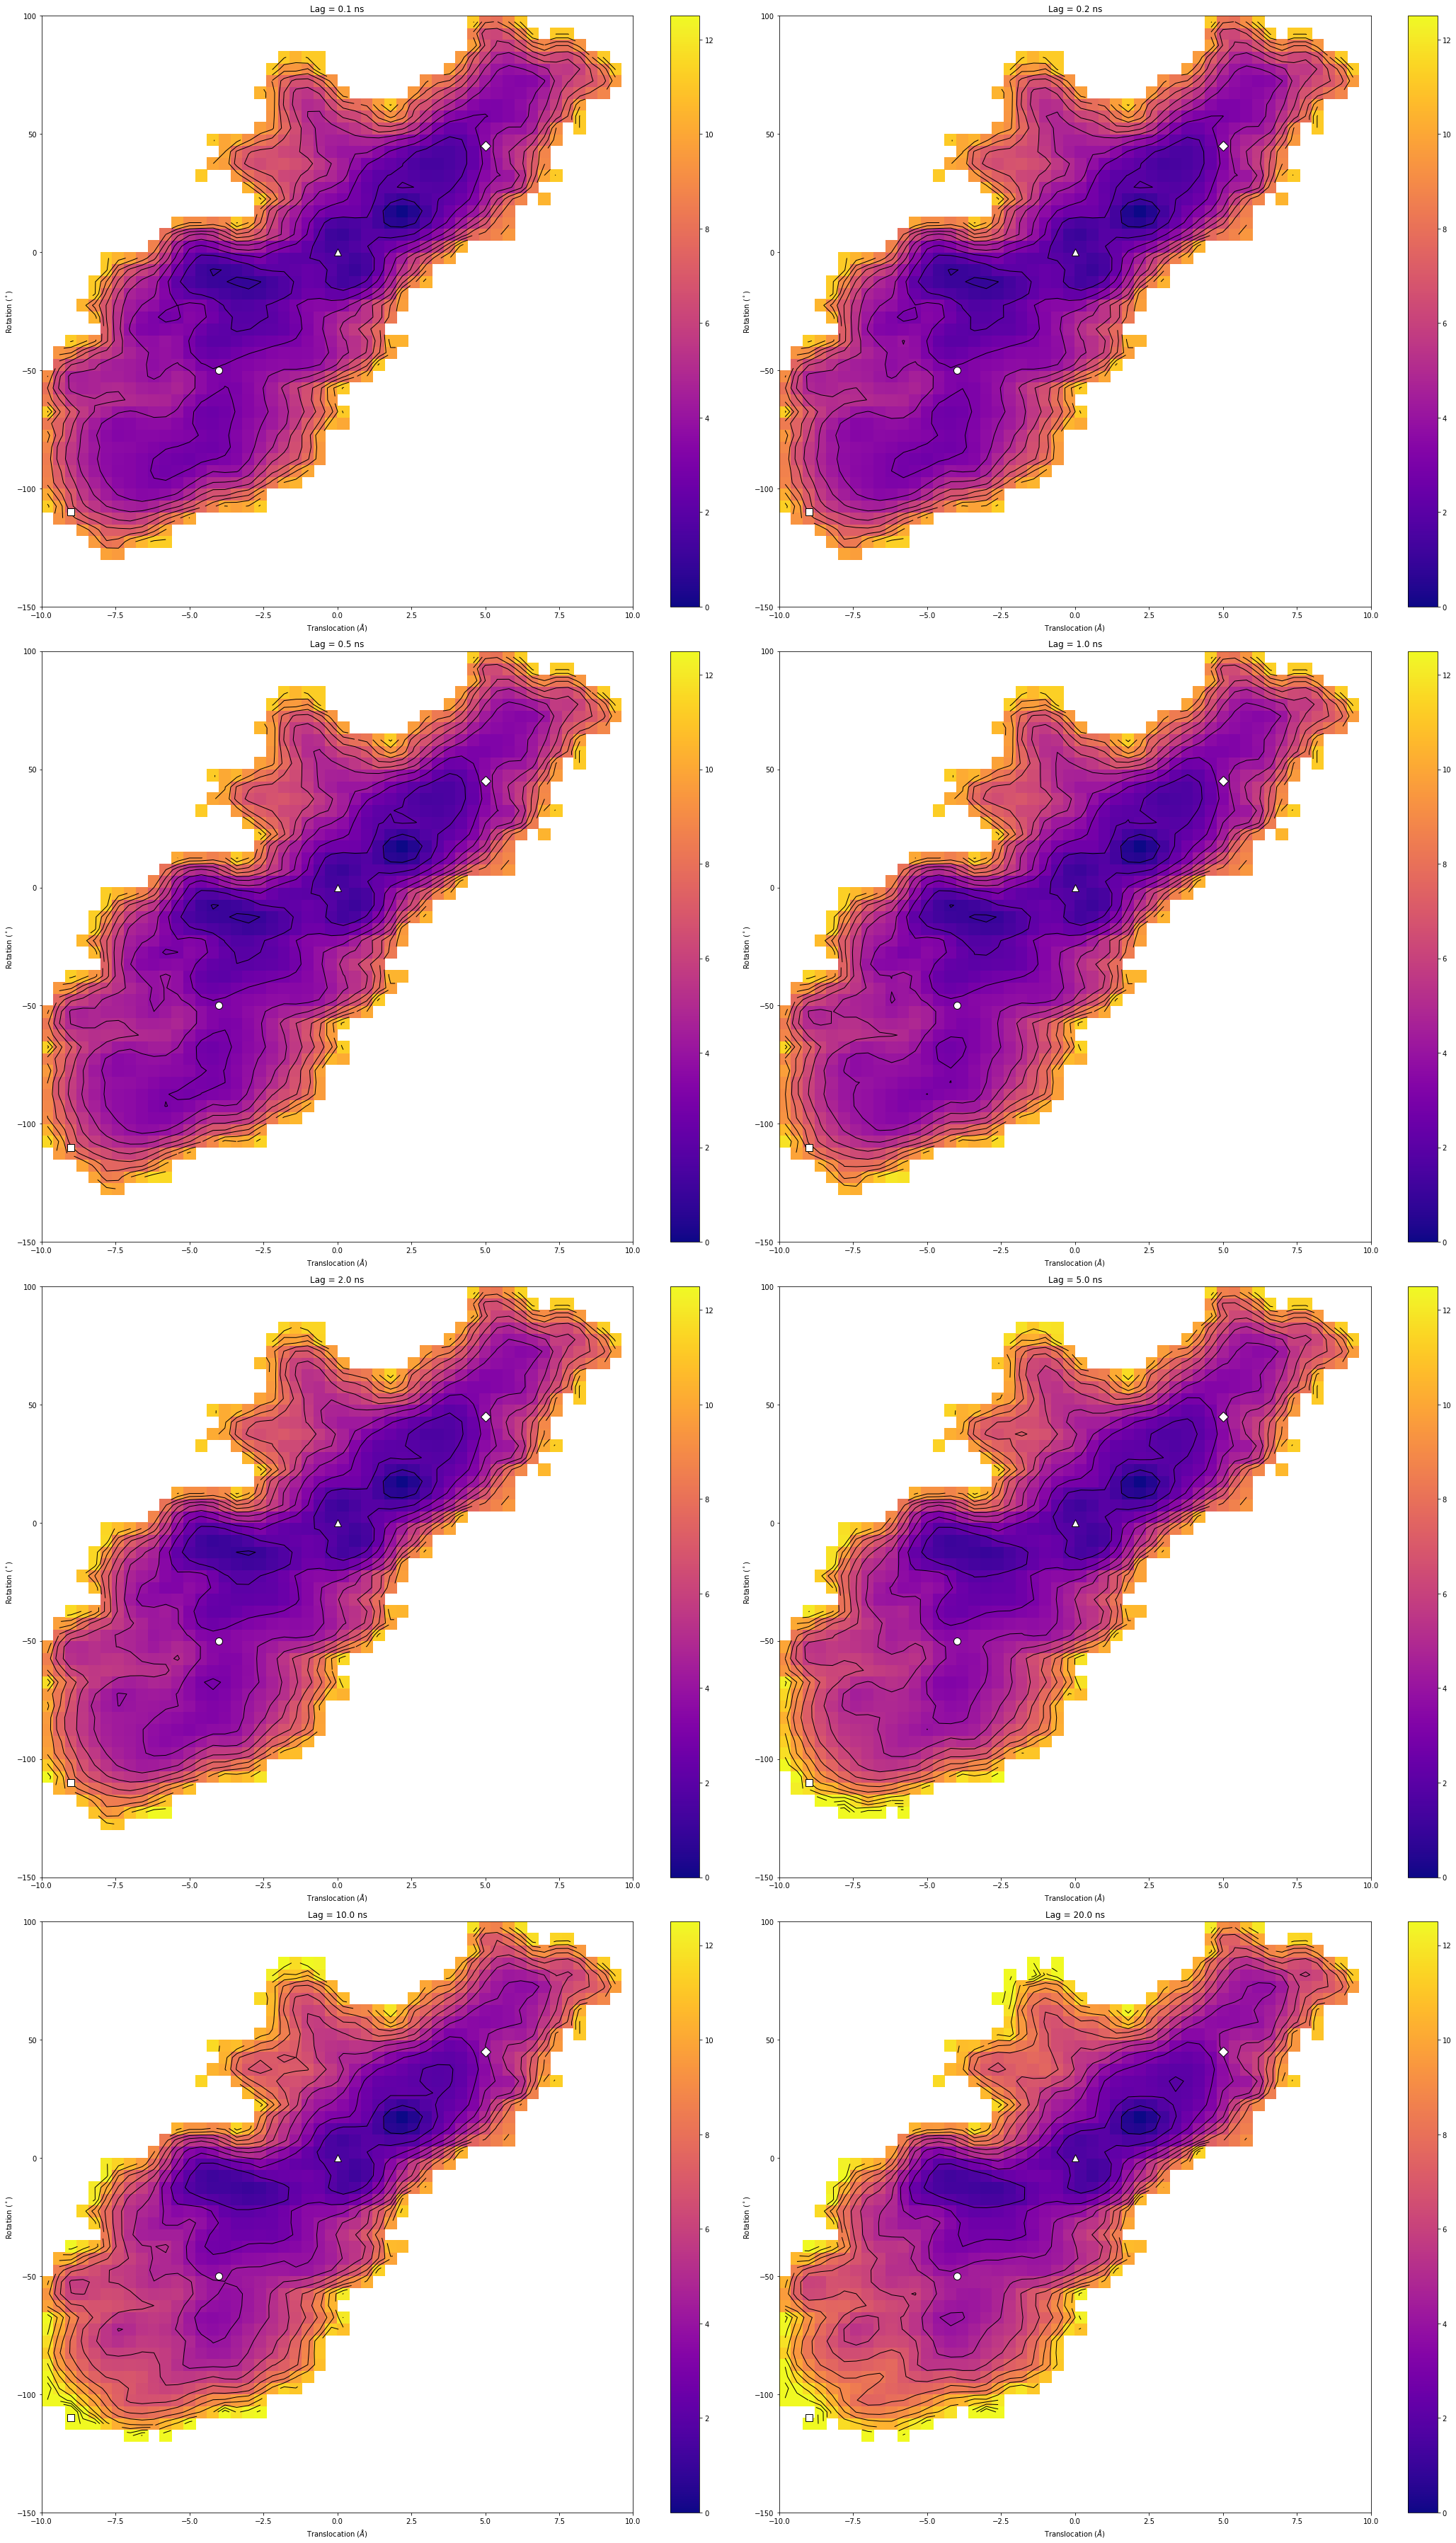

In [38]:
clines = np.linspace(0, 15, 16)
centerx = (xrange[1:] + xrange[:-1]) / 2
centery = (yrange[1:] + yrange[:-1]) / 2

f, axes = plt.subplots(4, 2, figsize=(30, 50))
for i, (lag, ax, pmf) in enumerate(zip(lags, axes.flat, pmfs)):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xrange, yrange, diff, cmap="plasma", vmax=12.5)
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()

## Feature 4